# **PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle**

In [161]:
# БИБЛИОТЕКИ

import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import re
import seaborn as sns
from geopy.distance import geodesic as GD # для работы с координатами
from matplotlib import pyplot as plt
from IPython.display import display
import logging
from comet_ml import Experiment


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки для обучения модели:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

ОПИСАНИЕ ДАННЫХ

1. **hotel_address** — адрес отеля;
2. **review_date** — дата, когда рецензент разместил соответствующий отзыв;
3. **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
4. **hotel_name** — название отеля;
5. **reviewer_nationality** — страна рецензента;
6. **negative_review** — отрицательный отзыв, который рецензент дал отелю;
7. **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
8. **positive_review** — положительный отзыв, который рецензент дал отелю;
9. **review_total_positive_word_counts** — общее количество слов в положительном отзыве.
10. **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
11. **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
12. **total_number_of_reviews** — общее количество действительных отзывов об отеле;
13. **tags** — теги, которые рецензент дал отелю;
14. **days_since_review** — количество дней между датой проверки и датой очистки;
15. **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
16. **lat** — географическая широта отеля;
17. **lng** — географическая долгота отеля.

In [162]:
hotels = pd.read_csv('data/hotels.csv')
display(hotels.head(3))
display(hotels.info())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

***
## **Создание и преобразвание признаков**

### **Признак hotel_address**

- возможно получить страну отеля (новый признак - 'country_of_hotel')
- возможно получить город из страны отеля (новый признак - 'city_of_hotel')

In [163]:
# получим страну и город из адреса отеля

# составим список всех стран из признака национальности автора обзора
country_set = set(hotels['reviewer_nationality'].str.strip())
country_set.remove('')
display(len(country_set)) # - всего 224 страны, этого должно хватить для вычленения страны из признака адреса отеля

# Функция для поиска страны с конца строки в нашем датафрейме
def get_countries(strs, countries):
    countries_series = []
    for string in strs:
        for country in countries:
            if country in ' '.join(string.split()[-2:]):
                countries_series.append(country)
    countries_series = pd.Series(countries_series)
    return countries_series

country_of_hotel = get_countries(hotels['hotel_address'],country_set)
hotels['country_of_hotel'] = country_of_hotel
display(country_of_hotel.value_counts())

224

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
dtype: int64

In [164]:
# функция для поиска города отеля
def get_cities(strs,country):
    cities_series = []
    for string in range(0,strs.shape[0]):
        if country.iloc[string]=='United Kingdom':
            cities_series.append(''.join(strs.iloc[string].split()[-5:-2][0]))
        else:
            cities_series.append(''.join(strs.iloc[string].split()[-5:][3]))
    cities_series = pd.Series(cities_series)
    return cities_series

city_of_hotel = get_cities(hotels['hotel_address'],hotels['country_of_hotel'])
hotels['city_of_hotel'] = city_of_hotel
display(city_of_hotel.value_counts())

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
dtype: int64

### **Признак latitude-longitude**

- можем вычислить примерное расстояние до центра города от отеля (новый признак - 'distance_to_citycenter')

In [165]:
# создадим признаки координат центра города (инфа взята с сайта https://www.gps-coordinates.net/)
latitude_by_city={'London':51.5073219,'Barcelona':41.3828939,'Paris':48.8588897,'Amsterdam':52.3727598,'Vienna':48.2083537,'Milan':45.4641943}
longitude_by_city={'London':-0.1276474,'Barcelona':2.1774322,'Paris':2.320041,'Amsterdam':4.8936041,'Vienna':16.3725042,'Milan':9.1896346}


latitude_by_city_list=[]
for i in range(0,hotels.shape[0]):
    for key, value in latitude_by_city.items():
        if key==hotels['city_of_hotel'][i]:
            latitude_by_city_list.append(value)
hotels['latitude_by_city']=latitude_by_city_list

longitude_by_city_list=[]
for i in range(0,hotels.shape[0]):
    for key, value in longitude_by_city.items():
        if key==hotels['city_of_hotel'][i]:
            longitude_by_city_list.append(value)
hotels['longitude_by_city']=longitude_by_city_list

display(hotels['longitude_by_city'])

# вычислим расстояние от отеля до центра города
def get_center_dist(lat_1,long_1,lat_2,long_2):
    distance = []
    for i in range(0,lat_1.shape[0]):
        if not np.isnan(lat_1[i]):
            distance.append(GD((lat_1[i],long_1[i]), (lat_2[i],long_2[i])).km)
        else:
            distance.append(np.nan)
    return distance

distance_to_citycenter = get_center_dist(hotels['lat'],hotels['lng'],hotels['latitude_by_city'],hotels['longitude_by_city'])
hotels['distance_to_citycenter'] = distance_to_citycenter
display(hotels['distance_to_citycenter'].value_counts())

0         -0.127647
1         -0.127647
2          2.320041
3          2.320041
4          4.893604
            ...    
386798    -0.127647
386799    16.372504
386800    -0.127647
386801    -0.127647
386802    -0.127647
Name: longitude_by_city, Length: 386803, dtype: float64

7.275664    3587
0.631031    3206
1.044115    3095
4.542343    2688
3.465016    2379
            ... 
3.201518       7
6.311114       7
6.575847       6
2.747701       6
4.619540       5
Name: distance_to_citycenter, Length: 1472, dtype: int64

### **Признак tags**

- можем создать бинарный признак по типу поездки по наличию тега **'Leisure trip'** в обзоре (новый признак - 'trip_type'), где 0 - отдых, 1 - деловая поездка
- можем создать бинарный признак по наличию тегов **'Family with young children'** и **'Family with older children'** в обзоре (новый признак - 'family'), где 0 - отсутствие, а 1 - наличие данного тэга
- можем создать признак по тегу **'Stayed ** nights'** в обзоре (новый признак - 'stayed_for'), основанный на количестве дней от 1 до 8, где цифры 1-7 - соответствующее количество дней, а 8 - всё, что больше семи дней
- можем создать признак по тегам **'solo'**, **'couple'**, **'group'** в обзоре (новый признак - 'group_type'), основанный на количестве людей в группе, от 1 до 3, где 1, 2, 3 - соло, пара, группа
-  можем создать признак по тегам **'Standard ...', 'Superior ...', 'Deluxe ...', 'Executive ...', и т. д.** в обзоре (новый признак - 'room_type'), основанный на категории комнаты

In [166]:
# форматируем строки с тегами в нормальные списки для удобства обработки
regex = """\'\s(.*?)\s\'""" # регулярное выражение
hotels['tags'] = hotels['tags'].str.findall(regex)

In [167]:
# создаём новый признак trip_type по типу поездки
hotels['trip_type'] = np.nan
for i in range(0,hotels.shape[0]):
    if 'Leisure trip' in hotels['tags'][i]:
        hotels['trip_type'][i]= 0
    elif 'Business trip' in hotels['tags'][i]:
        hotels['trip_type'][i]= 1
    else:
        hotels['trip_type'][i]= np.nan
hotels['trip_type']

0         0.0
1         1.0
2         0.0
3         0.0
4         1.0
         ... 
386798    0.0
386799    0.0
386800    1.0
386801    0.0
386802    0.0
Name: trip_type, Length: 386803, dtype: float64

In [168]:
# создаём новый признак family для обзорщиков, заселявшихся с семьёй
hotels['family'] = np.nan
for i in range(0,hotels.shape[0]):
    if ('Family with older children' in hotels['tags'][i]) or ('Family with young children' in hotels['tags'][i]):
        hotels['family'][i]= 1
    else:
        hotels['family'][i]= 0
hotels['family'] = hotels['family'].astype(int)
hotels['family'].value_counts()

0    321165
1     65638
Name: family, dtype: int64

In [169]:
# создаём признак stayed_for по количеству дней
nights = [] # сюда запишем вычлененные теги
for i in range(0,hotels.shape[0]):
    nights.append(",".join(s for s in hotels['tags'][i] if 'Stayed '.lower() in s.lower()))
hotels['stayed_for'] = nights
hotels['stayed_for'] = hotels['stayed_for'].str.findall('\S+\s(\d*)').apply(', '.join)
# заполняем 146 пропусков наиболее часто встречающимся тегом - 1 день
for i in range(0,hotels.shape[0]):
    if hotels['stayed_for'][i]=='':
        hotels['stayed_for'][i]='1'
hotels['stayed_for'] = hotels['stayed_for'].astype(int)
# преобразуем всё, что больше 7 в 8 (нормализация данных)
for i in range(0,hotels.shape[0]):
    if hotels['stayed_for'][i]>7:
        hotels['stayed_for'][i]=8
hotels['stayed_for'].value_counts()

1    145519
2    100263
3     72000
4     35748
5     15611
6      7399
7      5549
8      4714
Name: stayed_for, dtype: int64

In [170]:
# создаём признак group_type по размеру группы
hotels['group_type'] = np.nan
for i in range(0,hotels.shape[0]):
    if 'Solo traveler' in hotels['tags'][i]:
        hotels['group_type'][i]= 1
    elif 'Couple' in hotels['tags'][i]:
        hotels['group_type'][i]= 2
    elif 'Group' in hotels['tags'][i]:
        hotels['group_type'][i]= 3
    else:
        hotels['group_type'][i]= np.nan
hotels['group_type'].value_counts()

2.0    189212
1.0     81235
3.0     49088
Name: group_type, dtype: int64

In [171]:
# создаём признак room_type по категории номера
rooms = hotels['tags'].apply(', '.join) # сюда запишем вычлененные теги
regex = 'Deluxe.*?Room.*?,|Classic.*?Room.*?,|Superior.*?Room.*?,|Executive.*?Room.*?,|Standard.*?Room.*?,|Double.*?Room.*?,|Twin.*?Room.*?,'
rooms = rooms.str.findall(regex, re.I).apply(', '.join)
rooms = rooms.str.replace(',','').str.lower()
rooms = rooms.str.split()
for i in range(0,rooms.shape[0]):
    if rooms[i]==[]:
        rooms[i]='standard'
    for item in rooms[i]:
        if item in ['deluxe','classic','superior','executive','standard','double','twin']:
            rooms[i]=item

hotels['room_type'] = rooms

<AxesSubplot:>

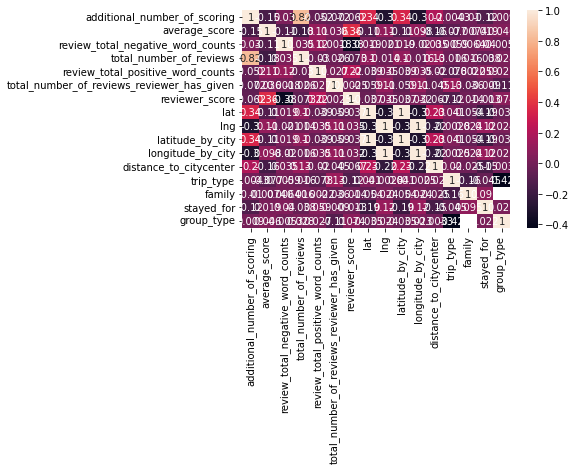

In [172]:
sns.heatmap(hotels.corr(), annot = True)